In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval, SqrtStretch
from astropy.io import fits
import sunpy
import sunpy.map
aia_193_cm = plt.get_cmap("sdoaia193")
import juanfit
import cmcrameri.cm as cmcm


In [4]:
with fits.open("../../src/CoMP/new_l2/20170821.comp.1074.l2/20170821.174607.comp.1074.dynamics.fts.gz") as hdul:
    hdul.info()
    header = hdul[0].header
    intensity = np.copy(hdul[1].data)
    enhanced_intensity = np.copy(hdul[2].data)
    vlos = np.copy(hdul[3].data)
    dlamb = np.copy(hdul[4].data)

Filename: ../../src/CoMP/new_l2/20170821.comp.1074.l2/20170821.174607.comp.1074.dynamics.fts.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   ()      
  1  Intensity     1 ImageHDU        38   (620, 620)   float32   
  2  Enhanced Intensity    1 ImageHDU        38   (620, 620)   uint8   
  3  Corrected LOS velocity    1 ImageHDU        39   (620, 620)   float32   
  4  Line Width    1 ImageHDU        38   (620, 620)   float32   


In [5]:
header

SIMPLE  =                    T / Written by IDL:  Tue Jun 21 10:59:58 2022      
BITPIX  =                  -32 /bits per data value                             
NAXIS   =                    0 /number of axes                                  
EXTEND  =                    T /file may contain extensions                     
N_EXT   =                   15 / Number of extensions                           
TIMESYS = 'UTC     '           / Coordinated Universal Time                     
DATE-OBS= '2017-08-21'         / [UTC] OBSERVATION DATE: CCYY-MM-DD             
TIME-OBS= '17:46:07'           / [UTC] OBSERVATION TIME: HH:MM:SS               
ORIGIN  =           'HAO/NCAR' /                                                
INSTRUME=               'COMP' / CORONAL MULTICHANNEL POLARIMETER               
TELESCOP=     '20 CM ONE SHOT' /                                                
LOCATION=               'MLSO' /                                                
OBJECT  = 'corona  '        

In [6]:
def plot_colorbar(im,ax,bbox_to_anchor=(1.02, 0., 1, 1),width="3%",height="100%",
                        loc="lower left",fontsize=14,orientation="vertical",color="white"):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    # clb_ax.spines["bottom"].set_color(colors)
    # clb_ax.spines["top"].set_color(colors)
    clb_ax.tick_params(labelsize=fontsize,color=color,labelcolor=color,width=2,which="both")
    clb.outline.set_edgecolor(color)
    
    return clb, clb_ax

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

In [12]:
def plot_comp_data(filename):
    with fits.open(filename) as hdul:
        header = hdul[0].header
        intensity = np.copy(hdul[1].data)
        enhanced_intensity = np.copy(hdul[2].data)
        vlos = np.copy(hdul[3].data)
        dlamb = np.copy(hdul[4].data)
    
    
    fig, axes = plt.subplots(2,2,figsize=(12,12),constrained_layout=True)

    nx, ny = 620, 620
    xcoord = np.linspace(1 - header["CRPIX1"], nx - header["CRPIX1"], nx)*header["CDELT1"]
    ycoord = np.linspace(1 - header["CRPIX2"], nx - header["CRPIX2"], ny)*header["CDELT2"]

    norm_int = ImageNormalize(data=intensity,stretch=SqrtStretch())

    im_int = axes[0,0].pcolormesh(xcoord, ycoord, intensity,cmap=aia_193_cm,norm=norm_int,
                    shading="auto",rasterized=True)


    clb_int, clb_ax_int = plot_colorbar(im_int,axes[0,0],bbox_to_anchor=(0.25,0.4,0.5,0.2),width="100%",height="20%",
                                        fontsize=16,orientation="horizontal")
    clb_ax_int.xaxis.set_minor_locator(AutoMinorLocator())
    clb_ax_int.tick_params(which="major",length=6)
    clb_ax_int.tick_params(which="minor",length=4)
    axes[0,0].text(0.5,0.6,r"\textbf{CoMP Fe \textsc{xiii} 1074.7 nm}",fontsize=18,transform=axes[0,0].transAxes,color="white",va="center",ha="center")
    axes[0,0].text(0.5,0.55,r"\textbf{"+ header["TIME-OBS"] +"}",fontsize=18,transform=axes[0,0].transAxes,color="white",va="center",ha="center")
    axes[0,0].text(0.5,0.5,r"\textbf{Intensity}",fontsize=18,transform=axes[0,0].transAxes,color="white",va="center",ha="center")

    im_enint = axes[0,1].pcolormesh(xcoord, ycoord, enhanced_intensity,cmap=aia_193_cm,
                    shading="auto",rasterized=True)

    clb_enint, clb_ax_enint = plot_colorbar(im_enint,axes[0,1],bbox_to_anchor=(0.25,0.4,0.5,0.2),width="100%",height="20%",
                                        fontsize=16,orientation="horizontal")
    clb_ax_enint.xaxis.set_minor_locator(AutoMinorLocator())
    clb_ax_enint.tick_params(which="major",length=6)
    clb_ax_enint.tick_params(which="minor",length=4)
    axes[0,1].text(0.5,0.5,r"\textbf{Enhanced Intensity}",fontsize=18,transform=axes[0,1].transAxes,color="white",va="center",ha="center")

    im_vlos = axes[1,0].pcolormesh(xcoord, ycoord, -vlos-2,cmap=cmcm.vik_r,vmin=-10,vmax=10,
                    shading="auto",rasterized=True)

    clb_vlos, clb_ax_vlos = plot_colorbar(im_vlos,axes[1,0],bbox_to_anchor=(0.25,0.4,0.5,0.2),width="100%",height="20%",
                                        fontsize=16,orientation="horizontal",color="black")
    clb_ax_vlos.xaxis.set_minor_locator(AutoMinorLocator())
    clb_ax_vlos.tick_params(which="major",length=6)
    clb_ax_vlos.tick_params(which="minor",length=4)
    axes[1,0].text(0.5,0.5,r"$\boldsymbol{v_{\rm LOS}\ \mathrm{[km\,s^{-1}]}}$",fontsize=18,transform=axes[1,0].transAxes,
                color="black",va="center",ha="center")

    im_dlamb = axes[1,1].pcolormesh(xcoord, ycoord, dlamb,cmap=cmcm.batlowK,vmin=30,vmax=45,
                    shading="auto",rasterized=True)

    clb_dlamb, clb_ax_dlamb = plot_colorbar(im_dlamb,axes[1,1],bbox_to_anchor=(0.25,0.4,0.5,0.2),width="100%",height="20%",
                                        fontsize=16,orientation="horizontal")
    clb_ax_dlamb.xaxis.set_minor_locator(AutoMinorLocator())
    clb_ax_dlamb.tick_params(which="major",length=6)
    clb_ax_dlamb.tick_params(which="minor",length=4)
    axes[1,1].text(0.5,0.5,r"$\boldsymbol{v_{\rm eff}\ \mathrm{[km\,s^{-1}]}}$",fontsize=18,transform=axes[1,1].transAxes,
                color="white",va="center",ha="center")

    xlim_zoomin = [-1500,-400]
    ylim_zoomin = [-900,800]

    for ax_ in axes.flatten():
        ax_.set_aspect(1)
        ax_.tick_params(labelsize=16)
        ax_.add_patch(create_limb_circle(header["RSUN"]))
        # ax_.set_xlim(xlim_zoomin)
        # ax_.set_ylim(ylim_zoomin)
    fig.patch.set_facecolor("white")
    axes[0,0].set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=18)
    axes[1,0].set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=18)
    axes[1,0].set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=18)
    axes[1,1].set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=18)

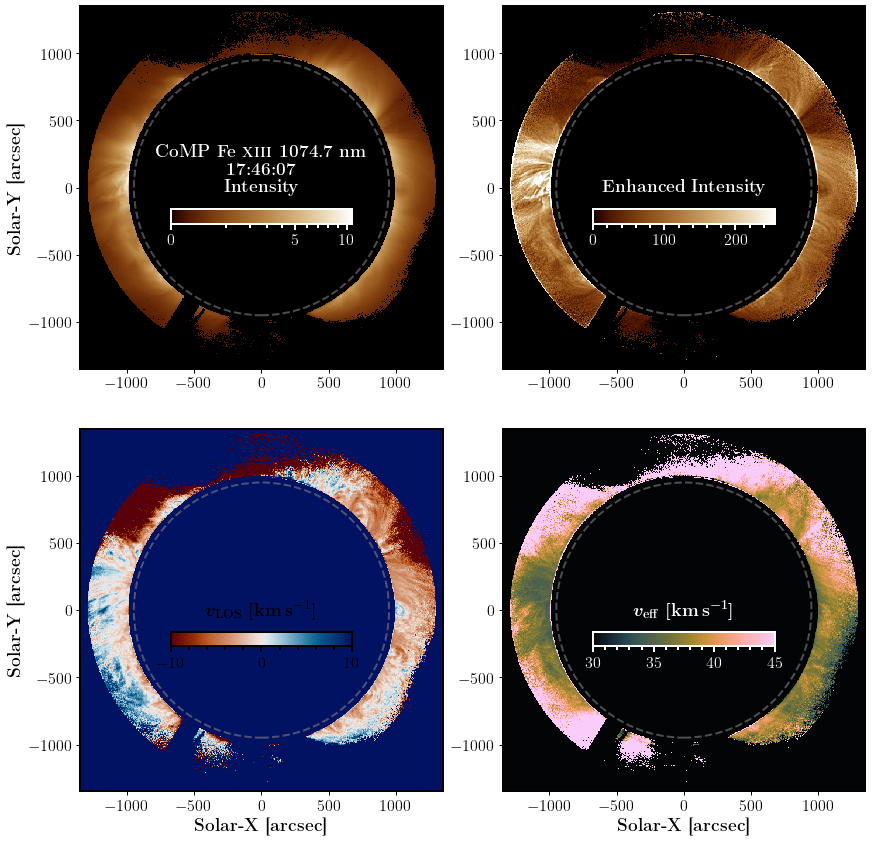

In [13]:
plot_comp_data("../../src/CoMP/new_l2/20170821.comp.1074.l2/20170821.174607.comp.1074.dynamics.fts.gz")